C:\Users\monicastebbins\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:30:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 1.0
ROC-AUC: 0.9999999999999999
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1467
         1.0       1.00      1.00      1.00       741

    accuracy                           1.00      2208
   macro avg       1.00      1.00      1.00      2208
weighted avg       1.00      1.00      1.00      2208



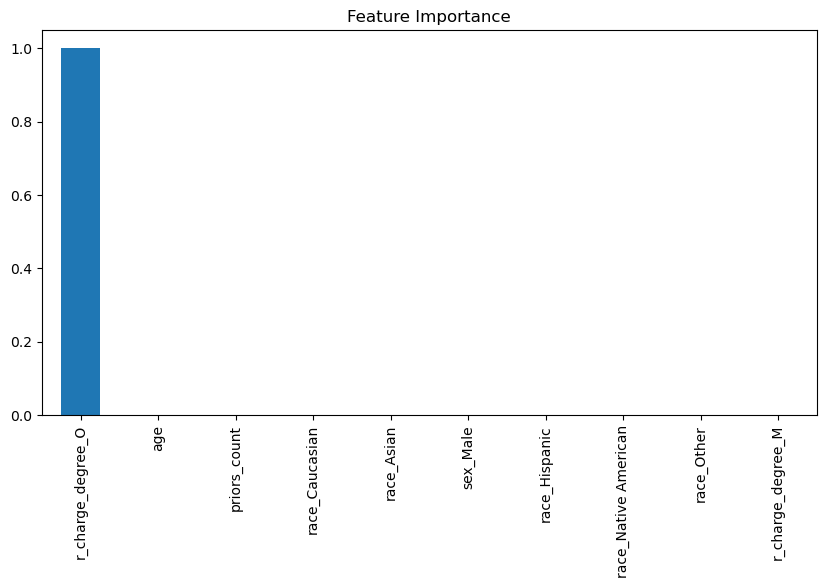

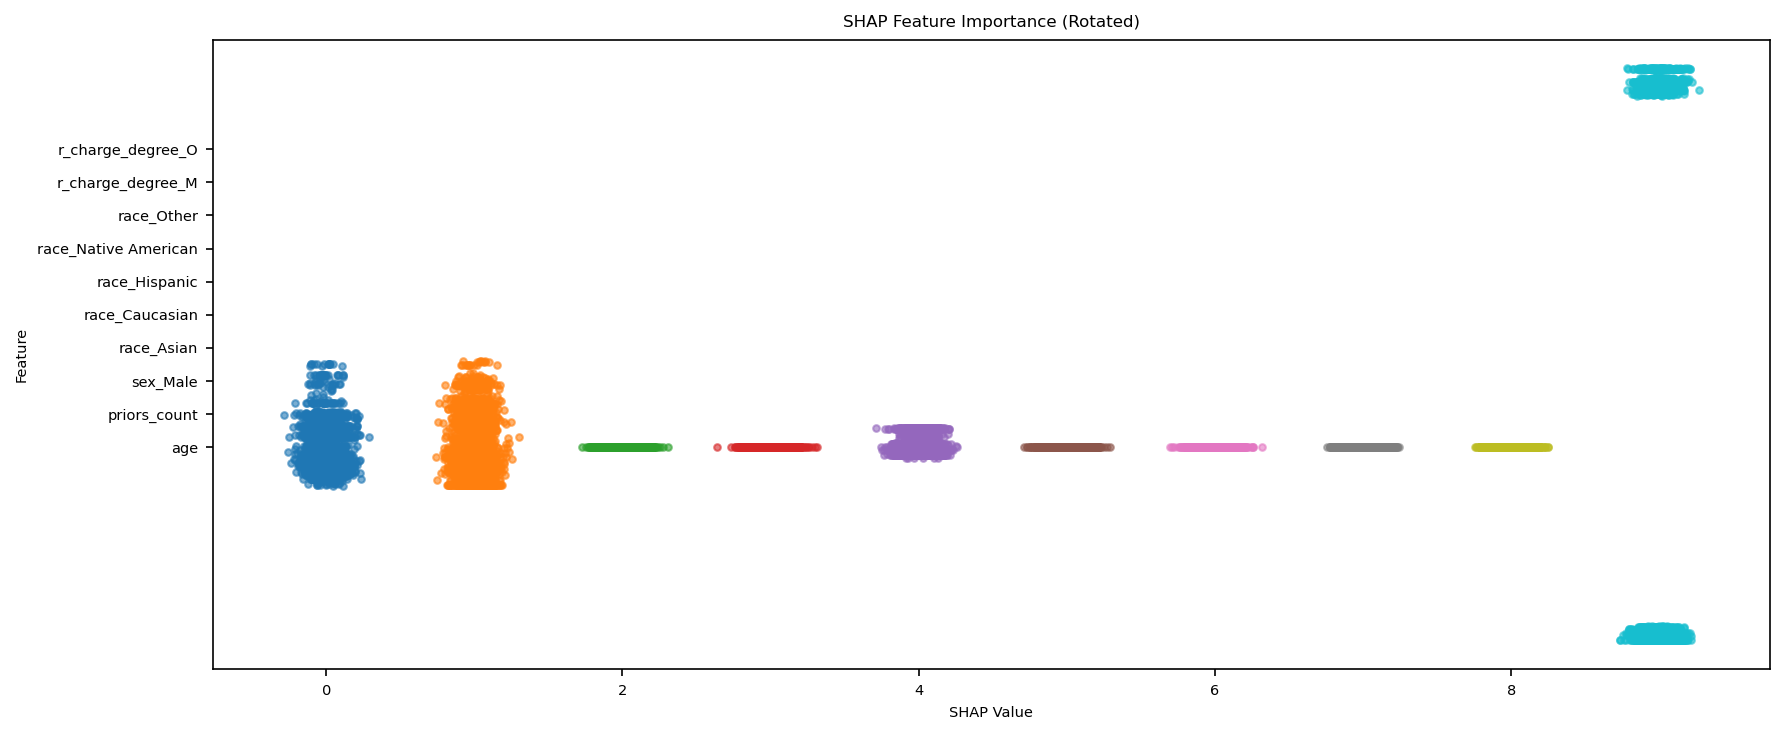

✅ Top 20 highest-risk CSV saved!


In [27]:
# -------------------------------
# 0️⃣ Imports
# -------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)
%matplotlib inline

# -------------------------------
# 1️⃣ Load Dataset
# -------------------------------
url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores.csv"
df = pd.read_csv(url)

# Keep relevant columns and drop missing targets
df = df.dropna(subset=['is_recid'])
features = ['age', 'priors_count', 'sex', 'race', 'r_charge_degree']
X = pd.get_dummies(df[features], drop_first=True)
X = X.fillna(0).astype(float)
y = df['is_recid'].map({0:0, 1:1})
mask = y.notna()
X = X[mask]
y = y[mask]
df = df[mask]  

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)
# -------------------------------
# 2️⃣ Split Data
# -------------------------------
X_train, X_test, y_train, y_test, df_train, df_test = train_test_split(
    X, y, df, test_size=0.2, random_state=42, stratify=y
)

# -------------------------------
# 3️⃣ Train XGBoost Model
# -------------------------------
model = XGBClassifier(
    n_estimators=200,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
model.fit(X_train, y_train)

# -------------------------------
# 4️⃣ Predict Probabilities
# -------------------------------
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:,1]  # probability for positive class

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))
print(classification_report(y_test, y_pred))

# 8. Feature Importance
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
importances.plot(kind='bar', figsize=(10,5))
plt.title("Feature Importance")
plt.show()

pred_probs = model.predict_proba(X_test)[:,1]  # positive class
X_test_copy = X_test.copy()
X_test_copy['pred_proba'] = model.predict_proba(X_test)[:, 1]
X_test_copy['original_index'] = df_test.index  # preserve original index

# -------------------------------
# 5️⃣ SHAP Analysis
# -------------------------------
# Subsample for safe SHAP computation
#X_small = X_test_copy[X_train.columns].sample(n=100, random_state=42).astype(float)
#explainer = shap.Explainer(model, X_small)
#shap_values = explainer(X_small)

explainer = shap.Explainer(model, X_test)
shap_values = explainer(X_test)  # full X_test

# Extract positive class SHAP values
if hasattr(shap_values, "values") and shap_values.values.ndim == 3:
    shap_vals = shap_values.values[:, :, 1]
else:
    shap_vals = shap_values.values

# Remove all-NaN features
mask_valid = ~np.all(np.isnan(shap_vals), axis=0)
shap_vals = shap_vals[:, mask_valid]
X_valid = X_small.iloc[:, mask_valid]

# -------------------------------
# 6️⃣ Rotated Beeswarm Plot
# -------------------------------
plt.figure(figsize=(12,5), dpi=150)
for i, f in enumerate(X_valid.columns):
    y = np.random.normal(loc=i, scale=0.08, size=shap_vals.shape[0])
    plt.scatter(y, shap_vals[:, i], alpha=0.6, s=10)

plt.yticks(ticks=np.arange(len(X_valid.columns)), labels=X_valid.columns, fontsize=7)
plt.xticks(fontsize=7)
plt.ylabel("Feature", fontsize=7)
plt.xlabel("SHAP Value", fontsize=7)
plt.title("SHAP Feature Importance (Rotated)", fontsize=8)
plt.tight_layout()
plt.show()

# -------------------------------
# 7️⃣ Top 20 Highest-Risk Export
# -------------------------------
#top20 = X_test_copy.sort_values(by='pred_proba', ascending=False).head(20)

top20 = pd.DataFrame({
    'pred_proba': y_pred_proba,
    'original_index': X_test.index
}).sort_values(by='pred_proba', ascending=False).head(20)

top20 = top20.reset_index(drop=True)

output_rows = []
X_test_copy_reset = X_test_copy.reset_index(drop=True)

top20_reset = X_test_copy_reset.sort_values(by='pred_proba', ascending=False).head(20)

for pos, row in top20_reset.iterrows():
    shap_row = shap_values.values[pos]  # i matches X_test_copy index
    top_features = pd.Series(shap_row, index=X_test.columns).abs().sort_values(ascending=False).head(3)
    pred_probs = top20.loc[top20['original_index'] == idx, 'pred_proba'].values[0]
    original_row = df.loc[row['original_index']]
    output_rows.append({
        'index': idx,
        'name': original_row['name'] if 'name' in df.columns else f"id_{idx}",
        'dob': original_row['dob'],
        'age': original_row['age'],
        'race': original_row['race'],
        'priors_count': original_row['priors_count'],
        'c_charge_desc': original_row['c_charge_desc'],
        'pred_proba': pred_probs
    })

output_df = pd.DataFrame(output_rows)
output_df.to_csv("top20_highest_risk.csv", index=False)
print("✅ Top 20 highest-risk CSV saved!")
